# Spatial CV

Apply and compare:

- random CV,
- spatial CV,
- geo-attribute based CV.

We will study 2 geospatial datasets:

- domestic violence,
- obesity.


### Obesity prevalence

We use a fully-connected, deep neural network (with 9 hidden layers) to analyze obesity prevalence data in New York City (NYC), from a study in 2022. 

- The dependent variable is the obesity prevalence at the census tract level.
- The global Moran’s I is 0.740 (p < 0.001).
- The independent variables are 21 socioeconomic and demographic factors related to race and ethnicity, gender, age, education, income, and housing conditions.

#### Data partition

- Random CV: traditional 10-fold CV by randomly splitting all CBGs (Census Bloc Groups) into 10 subsets.
- Clustering-based spatial CV:  k-means clustering to split the whole data set into 10 clusters (i.e., k = 10).
- Geo-attribute-based spatial CV: Using a geo-attribute of the 5 boroughs of NYC, we split the data into these 5 boroughs.


Adapted from the [original version](https://github.com/geoai-lab/spatialCV).

Sun, K., Hu, Y., Lakhanpal, G., & Zhou, R.Z. (2023): Spatial cross-validation for GeoAI, In: S. Gao, Y. Hu, and W. Li (Eds), Handbook of Geospatial Artificial Intelligence, Taylor & Francis Group. [link](https://www.taylorfrancis.com/books/edit/10.1201/9781003308423)

In [9]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.cluster import KMeans
from scipy.spatial import distance

In [2]:
# Load the dataset for obesity prevalence prediction

df_obesity = pd.read_csv("./Data/Obesity/Obesity.csv")
df_obesity[["GEOID"]] = df_obesity[["GEOID"]].astype(str)
y = df_obesity['obesity_cr']
df_obesity.shape

(1995, 25)

In [3]:
# Define the predictors

using_columns = ['% Black','% Ame Indi and AK Native','% Asian','% Nati Hawa and Paci Island','% Hispanic or Latino','% male',
                 '% married','% age 18-29','% age 30-39','% age 40-49','% age 50-59','% age >=60','% <highschool',
                 'median income','% unemployment','% below poverty line','% food stamp/SNAP','median value units built',
                 'median year units built','% renter-occupied housing units','population density']
num_features = len(using_columns)
num_features

21

In [4]:
# Load the census tract shapefile of NYC

boundary = gpd.read_file("./Data/Obesity/NYC_CDC data_Tract_Ob_pro.shp")
boundary = boundary.to_crs("EPSG:4326")

In [5]:
# Create the geodataframe for the data

gdf_obesity = gpd.GeoDataFrame(df_obesity, geometry=gpd.points_from_xy(df_obesity['Lonpro'], df_obesity['Latpro']))

In [6]:
# Standardization function

def standarize_data(data, stats):
    return (data - stats['mean'])/ stats['std']

## Random CV

In [7]:
# random split

y_dnn_socio_predict = []
y_true = []

ten_fold = KFold(n_splits=10, shuffle=True, random_state=42)

i = 1

# Iterate through folds and train
for train_index, test_index in ten_fold.split(df_obesity):
    
    # Create train/test splits
    print("fold:", str(i))
    X_train, X_test = df_obesity.iloc[train_index], df_obesity.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train[using_columns]
    X_test = X_test[using_columns]
    
    training_stat = X_train.describe().transpose()
    scaled_X_train = standarize_data(X_train, training_stat)
    scaled_X_test = standarize_data(X_test, training_stat)

    # Define MLPRegressor model with early stopping and increased regularization
    dnn_model = MLPRegressor(hidden_layer_sizes=(160, 208, 160, 160, 256, 32, 240, 96, 208),
                     activation='relu',
                     solver='adam',
                     alpha=0.001,  # Increased L2 regularization to compensate for dropout
                     batch_size=32,
                     learning_rate_init=0.001,
                     max_iter=200,  # Increased max iterations to allow early stopping to take effect
                     early_stopping=True,  # Enables early stopping to prevent overfitting
                     validation_fraction=0.1,  # 10% of training data used for validation
                     verbose=False, #True,
                     random_state=42)
    
    # Train the model
    dnn_model.fit(scaled_X_train, y=y_train)
    
    # Predict using DNN model
    this_y_predict = dnn_model.predict(scaled_X_test).flatten()
    y_dnn_socio_predict = y_dnn_socio_predict + this_y_predict.tolist()
    y_true = y_true + y_test.tolist()
    
    i = i + 1

fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10


In [10]:
# Calculate and display RMSE & R2 
dnn_socio_rmse_rcv = root_mean_squared_error(y_true , y_dnn_socio_predict)
dnn_socio_r2_rcv = r2_score(y_true, y_dnn_socio_predict)
print("rmse: " + str(round(dnn_socio_rmse_rcv,4)), "r2: " + str(round(dnn_socio_r2_rcv,4)))

rmse: 2.0408 r2: 0.8798


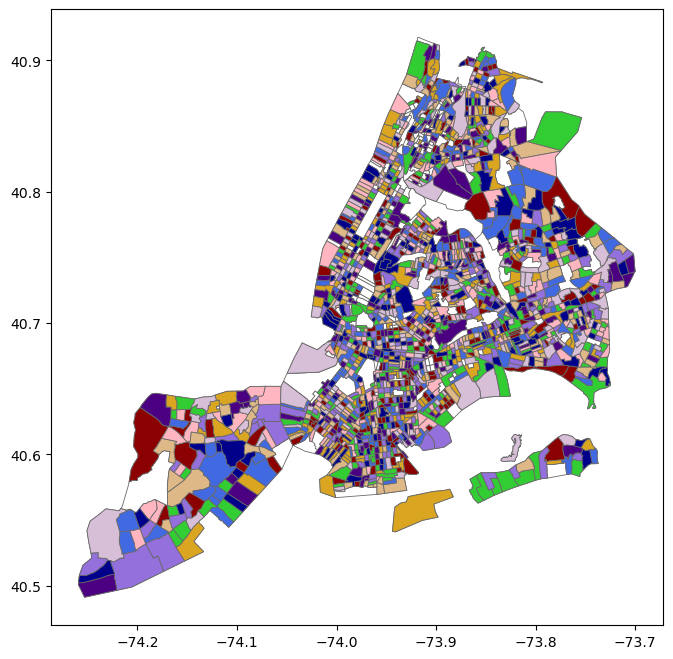

In [11]:
# Making the figure for spatial CV

# Create figure dimensions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)
color_list = ['darkred', 'goldenrod', 'limegreen', 'burlywood', 'royalblue', 'mediumpurple', 'lightpink', 'thistle', 'indigo', 'darkblue']

# Populate figure with data
i=0
for train_index, test_index in ten_fold.split(df_obesity):  
    test_index = df_obesity.iloc[test_index]["GEOID"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["GEOID"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

# Save and display figure
#plt.savefig('../Data/Obesity/Figs/random.png', dpi=300)
plt.show()

## Clustering-based spatial CV

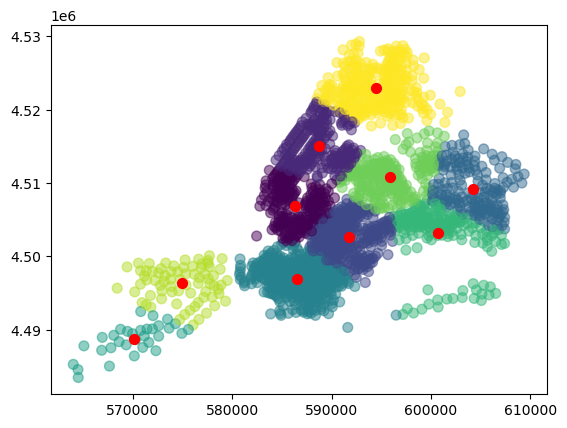

In [12]:
# Split the data based on their coordinates using k-means clustering algorithm

# Split data using kmeans
kmeans = KMeans(n_clusters=10, random_state=42).fit(df_obesity[['Lonpro','Latpro']])
centroids = kmeans.cluster_centers_

# Plot data clusters
plt.scatter(df_obesity['Lonpro'], df_obesity['Latpro'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [13]:
# Label the cluster index of each sample. 

df_obesity_cluster = df_obesity.copy()
df_obesity_cluster["cluster"] = kmeans.labels_.tolist()
df_obesity_cluster["cluster"].value_counts()

cluster
4    346
9    296
2    272
1    216
7    215
0    211
3    167
6    167
8     73
5     32
Name: count, dtype: int64

In [14]:
y_dnn_socio_predict = []
y_true = []

group_index = df_obesity_cluster['cluster'].values

group_kfold = GroupKFold(n_splits=10)

i = 1

# Iterate through folds and train
for train_index, test_index in group_kfold.split(df_obesity_cluster, y, group_index):
    print("fold:", str(i))

    # Create train/test splits
    X_train, X_test = df_obesity.iloc[train_index], df_obesity.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train[using_columns]
    X_test = X_test[using_columns]
    
    training_stat = X_train.describe().transpose()
    scaled_X_train = standarize_data(X_train, training_stat)
    scaled_X_test = standarize_data(X_test, training_stat)
    
    # Create DNN model
    # Define MLPRegressor model with early stopping and increased regularization
    dnn_model = MLPRegressor(hidden_layer_sizes=(160, 208, 160, 160, 256, 32, 240, 96, 208),
                     activation='relu',
                     solver='adam',
                     alpha=0.001,  # Increased L2 regularization to compensate for dropout
                     batch_size=32,
                     learning_rate_init=0.001,
                     max_iter=200,  # Increased max iterations to allow early stopping to take effect
                     early_stopping=True,  # Enables early stopping to prevent overfitting
                     validation_fraction=0.1,  # 10% of training data used for validation
                     verbose=False, #True,
                     random_state=42)
    
    dnn_model.fit(scaled_X_train, y_train)
    
    # Predict using DNN model
    this_y_predict = dnn_model.predict(scaled_X_test).flatten()
    y_dnn_socio_predict = y_dnn_socio_predict + this_y_predict.tolist()
    y_true = y_true + y_test.tolist()
    
    i = i + 1    

fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10


In [15]:
# Calculate and display RMSE & R2
dnn_socio_rmse_km = root_mean_squared_error(y_true , y_dnn_socio_predict)
dnn_socio_r2_km = r2_score(y_true, y_dnn_socio_predict)
print("rmse: " + str(round(dnn_socio_rmse_km,4)), "r2: " + str(round(dnn_socio_r2_km,4)))

rmse: 2.7386 r2: 0.7835


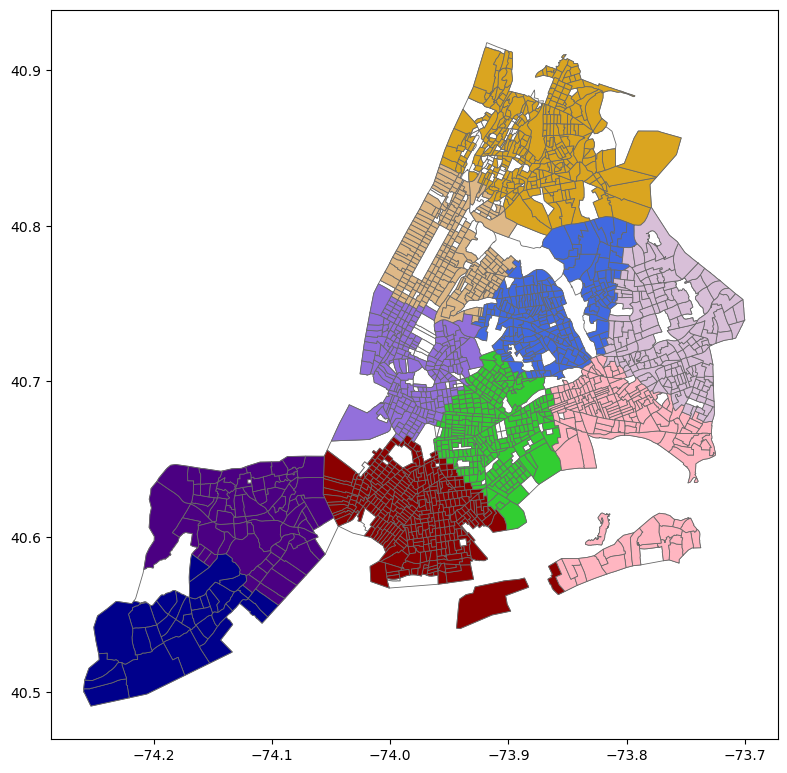

In [16]:
# Making a figure for cluster based spatial CV

# Create fig dimensions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig.tight_layout()
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)

# Populate figure with data
i=0
color_list = ['darkred', 'goldenrod', 'limegreen', 'burlywood', 'royalblue', 'mediumpurple', 'lightpink', 'thistle', 'indigo', 'darkblue']
for train_index, test_index in group_kfold.split(df_obesity_cluster, y, group_index):  
    test_index = df_obesity.iloc[test_index]["GEOID"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["GEOID"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

# Save and display figure
#plt.savefig('../Data/Obesity/Figs/cluster.png', dpi=300)
plt.show()

## Geo-attribute-based spatial CV

In [17]:
# load the file for showing which borough each census tract is located in.

gdf_tract_borough = gpd.read_file("./Data/Obesity/gdf_tract_borough.shp")

In [18]:
# Label the borough index of each census tract

df_obesity_block = df_obesity.merge(gdf_tract_borough[['GEOID','index_righ']], how='left', left_on="GEOID", right_on="GEOID")
df_obesity_block.head()

,GEOID,% Black,% Ame Indi and AK Native,% Asian,% Nati Hawa and Paci Island,% Hispanic or Latino,% male,% married,% age 18-29,% age 30-39,...,% below poverty line,% food stamp/SNAP,median value units built,median year units built,% renter-occupied housing units,population density,Lonpro,Latpro,obesity_cr,index_righ
0,36081046200,0.128637,0.001426,0.405733,0.000000,0.324729,0.429122,0.443847,0.207074,0.149173,...,0.086140,0.167808,566100,1964,0.776419,28106.912090,602380.0,4507260.0,26.6,4.0
1,36081045000,0.078431,0.000000,0.579115,0.000000,0.191518,0.447788,0.534483,0.176015,0.133151,...,0.071591,0.076923,585500,1939,0.326454,12744.813160,600955.0,4507720.0,19.6,4.0
2,36081045400,0.160195,0.008653,0.628800,0.000000,0.101176,0.526514,0.550474,0.151986,0.135123,...,0.147992,0.089735,168400,1954,0.558124,19521.893370,601697.0,4507560.0,21.5,4.0
3,36081045600,0.028744,0.000000,0.708775,0.000000,0.142209,0.486384,0.604982,0.216339,0.116490,...,0.170197,0.201201,650900,1939,0.279279,8153.246497,601862.0,4508000.0,18.6,4.0
4,36081044602,0.197928,0.011224,0.427585,0.016836,0.298295,0.462335,0.505800,0.136844,0.189294,...,0.325225,0.340757,281000,1957,0.869339,27255.666740,601380.0,4507060.0,30.6,4.0


In [19]:
df_obesity_block.index_righ.nunique()

5

In [20]:
y_dnn_socio_predict = []
y_true = []

block = df_obesity_block['index_righ'].values
group_kfold = GroupKFold(n_splits=5)

i = 1

# Iterate through folds divided based on the geo-attribute
for train_index, test_index in group_kfold.split(df_obesity_block, y, block):
    print("fold:", str(i))

    # Create train/test splits
    X_train, X_test = df_obesity.iloc[train_index], df_obesity.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train[using_columns]
    X_test = X_test[using_columns]
    
    training_stat = X_train.describe().transpose()
    scaled_X_train = standarize_data(X_train, training_stat)
    scaled_X_test = standarize_data(X_test, training_stat)

    
    # Create DNN model
    # Define MLPRegressor model with early stopping and increased regularization
    dnn_model = MLPRegressor(hidden_layer_sizes=(160, 208, 160, 160, 256, 32, 240, 96, 208),
                     activation='relu',
                     solver='adam',
                     alpha=0.001,  # Increased L2 regularization to compensate for dropout
                     batch_size=32,
                     learning_rate_init=0.001,
                     max_iter=200,  # Increased max iterations to allow early stopping to take effect
                     early_stopping=True,  # Enables early stopping to prevent overfitting
                     validation_fraction=0.1,  # 10% of training data used for validation
                     verbose=False, #True,
                     random_state=42)
    
    dnn_model.fit(scaled_X_train, y_train)
        
    # Predict using DNN model
    this_y_predict = dnn_model.predict(scaled_X_test).flatten()
    y_dnn_socio_predict = y_dnn_socio_predict + this_y_predict.tolist()
    y_true = y_true + y_test.tolist()
    
    i = i + 1

fold: 1
fold: 2
fold: 3
fold: 4
fold: 5


In [21]:
# Calculate and display RMSE & R2
dnn_socio_rmse_geo = root_mean_squared_error(y_true , y_dnn_socio_predict)
dnn_socio_r2_geo = r2_score(y_true, y_dnn_socio_predict)
print("rmse: " + str(round(dnn_socio_rmse_geo,4)), "r2: " + str(round(dnn_socio_r2_geo,4)))

rmse: 3.7466 r2: 0.5948


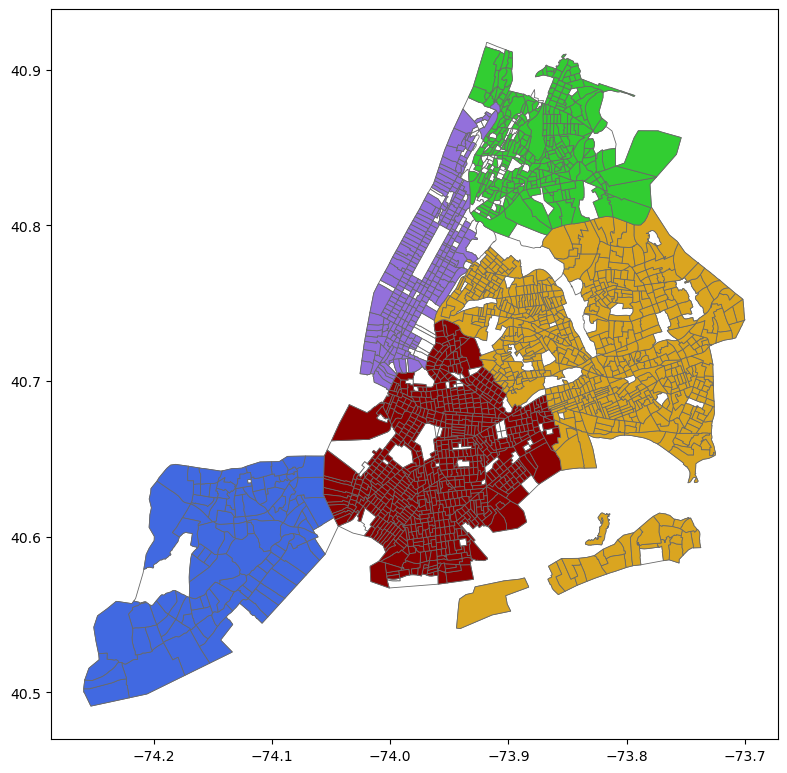

In [22]:
# Making a figure for geo-attribute based spatial CV

# Create figure dimensions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig.tight_layout()
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)

# Populate figure with data
i = 0
color_list = ['darkred', 'goldenrod', 'limegreen', 'mediumpurple', 'royalblue']
for train_index, test_index in group_kfold.split(df_obesity_block, y, block):  
    test_index = df_obesity.iloc[test_index]["GEOID"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["GEOID"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

# Save and display figure
#plt.savefig('../Data/Obesity/Figs/geo.png', dpi=300)
plt.show()

## Conclusions



In [25]:
import pandas as pd

# Define the results for each method
results = {
    "Method": ["Random CV", "Cluster CV", "Geo-based CV"],
    "RMSE": [dnn_socio_rmse_rcv, dnn_socio_rmse_km, dnn_socio_rmse_geo],
    "R²": [dnn_socio_r2_rcv, dnn_socio_r2_km, dnn_socio_r2_geo]
}

# Create a DataFrame
df = pd.DataFrame(results)

# Print the table
#print(df.to_string(index=False))
df

,Method,RMSE,R²
0,Random CV,2.040776,0.879763
1,Cluster CV,2.738582,0.783480
2,Geo-based CV,3.746603,0.594750


1. As can be seen from the Table, the overall pattern of the obtained performance scores holds, i.e., the scores from random CV are the highest compared with the scores obtained via the two spatial CV methods.
2. Random CV again generates many training and validation census tracts that are spatially adjacent, allowing the DNN model to “peek” into nearby validation census tracts during the training process.
3. The performance scores from random CV are 12% - 48% higher. In particular, the random CV scores are about 48% higher than the performance scores obtained via geo-attribute-based spatial CV.
4. Note that the spatial autocorrelation in the obesity prevalence data is higher than that in the domestic violence data used in the previous example. This higher spatial autocorrelation likely contributes to the higher overestimate of performance scores from random CV.
5. Using random CV in this case could present a relatively large overestimate of the model performance.